In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import copy

# Set seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# 1. Dataset & Task Generation
class MovingCircleTask:
    def __init__(self):
        # Task Distribution: radius=2, center ~ U[-3, 3]
        self.radius = 2.0
        self.cx = np.random.uniform(-3, 3)
        self.cy = np.random.uniform(-3, 3)

    def sample_data(self, k_samples):
        # Input space: x in [-5, 5]
        x = np.random.uniform(-5, 5, size=(k_samples, 2))

        # Calculate labels based on distance from center
        dists = np.sqrt((x[:, 0] - self.cx)**2 + (x[:, 1] - self.cy)**2)
        y = (dists < self.radius).astype(np.float32)

        return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32).unsqueeze(1)

In [ ]:

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        # Architecture: 2 -> 40 -> 40 -> 1
        self.net = nn.Sequential(
            nn.Linear(2, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x, params=None):
        # Normal forward pass
        if params is None:
            return self.net(x)

        # Functional forward pass (using specific weights for MAML inner loop)
        # We manually apply linear layers and ReLUs using the provided dictionary of weights
        x = torch.nn.functional.linear(x, params['net.0.weight'], params['net.0.bias'])
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.linear(x, params['net.2.weight'], params['net.2.bias'])
        x = torch.nn.functional.relu(x)
        x = torch.nn.functional.linear(x, params['net.4.weight'], params['net.4.bias'])
        return x

In [ ]:


def train_maml(meta_epochs=2000, k_shots=10):
    model = SimpleMLP()
    meta_optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    alpha = 0.1  # Inner loop learning rate

    print("Starting MAML Training...")
    loss_history = []

    for epoch in range(meta_epochs):
        meta_optimizer.zero_grad()

        # 1. Sample a Task
        task = MovingCircleTask()

        # 2. Support Set (Train) & Query Set (Test)
        x_support, y_support = task.sample_data(k_shots)
        x_query, y_query = task.sample_data(k_shots)

        # --- Inner Loop (Adaptation) ---
        # Clone weights to avoid mutating the meta-model in the inner loop
        fast_weights = dict(model.named_parameters())

        # Forward pass on Support
        pred_support = model(x_support, fast_weights)
        loss_support = loss_fn(pred_support, y_support)

        # Compute Gradients w.r.t fast_weights
        grads = torch.autograd.grad(loss_support, fast_weights.values(), create_graph=True)

        # Update weights (Gradient Descent Step) manually
        fast_weights = {
            name: param - alpha * grad
            for (name, param), grad in zip(fast_weights.items(), grads)
        }

        # --- Outer Loop (Meta-Objective) ---
        # Forward pass on Query using UPDATED weights
        pred_query = model(x_query, fast_weights)
        loss_query = loss_fn(pred_query, y_query)

        loss_query.backward()
        meta_optimizer.step()

        loss_history.append(loss_query.item())
        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{meta_epochs} | Meta Loss: {loss_query.item():.4f}")

    return model

# Run MAML Training
maml_model = train_maml(meta_epochs=2000)

Starting MAML Training...
Epoch 500/2000 | Meta Loss: 0.1592
Epoch 1000/2000 | Meta Loss: 0.1414
Epoch 1500/2000 | Meta Loss: 0.0888
Epoch 2000/2000 | Meta Loss: 0.3307


In [ ]:

def train_baseline(epochs=2000):
    model = SimpleMLP()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.BCEWithLogitsLoss()

    print("\nStarting Baseline Training...")
    for epoch in range(epochs):
        # Sample random data from random tasks (Joint Training)
        task = MovingCircleTask()
        x, y = task.sample_data(32) # Batch size 32

        optimizer.zero_grad()
        pred = model(x)
        loss = loss_fn(pred, y)
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 500 == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.4f}")

    return model

# Run Baseline Training
baseline_model = train_baseline(epochs=2000)


Starting Baseline Training...
Epoch 500/2000 | Loss: 0.1365
Epoch 1000/2000 | Loss: 0.7923
Epoch 1500/2000 | Loss: 0.2741
Epoch 2000/2000 | Loss: 0.2866


Test Task Center: (1.43, -0.43)


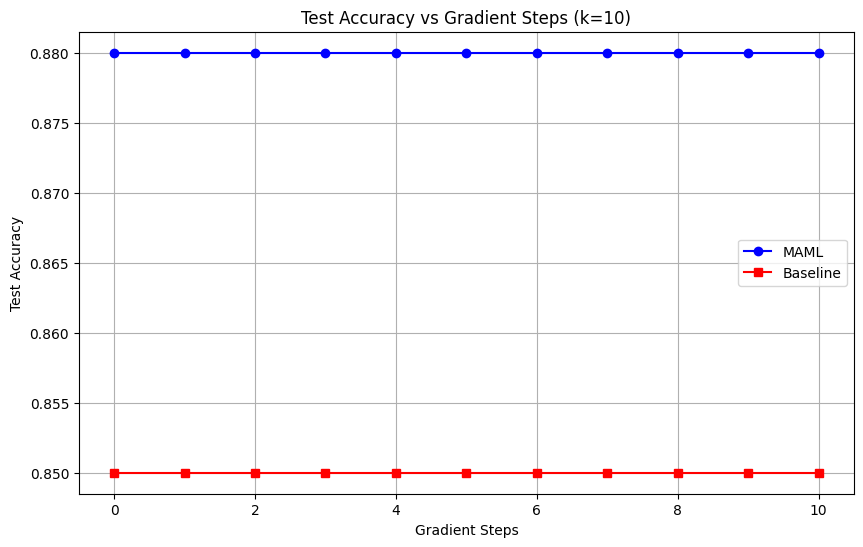

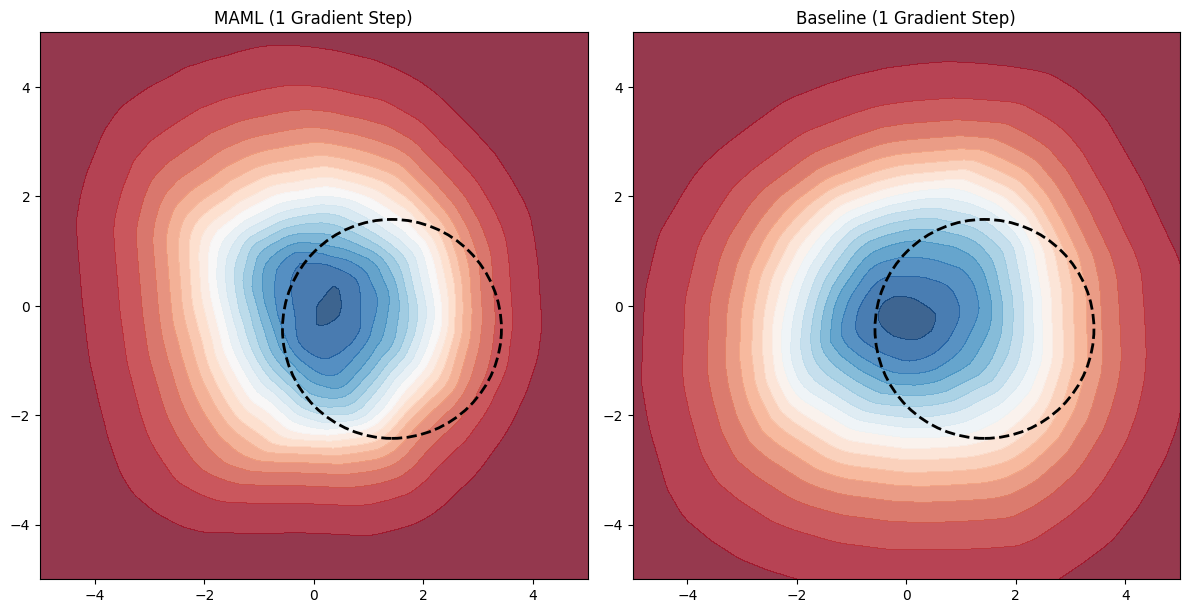

In [ ]:

def evaluate_finetuning(model, task, steps=10, k_shots=10):
    # Create a deep copy to avoid modifying the original trained model
    ft_model = copy.deepcopy(model)
    optimizer = optim.SGD(ft_model.parameters(), lr=0.1)
    loss_fn = nn.BCEWithLogitsLoss()

    # Support Set for adaptation
    x_support, y_support = task.sample_data(k_shots)
    # Large Query Set for robust evaluation
    x_test, y_test = task.sample_data(100)

    accuracies = []

    # Step 0 (Pre-update accuracy)
    with torch.no_grad():
        preds = ft_model(x_test)
        acc = ((torch.sigmoid(preds) > 0.5) == y_test).float().mean().item()
        accuracies.append(acc)

    # Fine-tuning loop
    for _ in range(steps):
        optimizer.zero_grad()
        pred_supp = ft_model(x_support)
        loss = loss_fn(pred_supp, y_support)
        loss.backward()
        optimizer.step()

        with torch.no_grad():
            preds = ft_model(x_test)
            acc = ((torch.sigmoid(preds) > 0.5) == y_test).float().mean().item()
            accuracies.append(acc)

    return accuracies, ft_model

def plot_heatmap(model, task, title, ax):
    # Create meshgrid
    xx = np.linspace(-5, 5, 100)
    yy = np.linspace(-5, 5, 100)
    X, Y = np.meshgrid(xx, yy)
    grid_points = np.vstack([X.ravel(), Y.ravel()]).T
    grid_tensor = torch.tensor(grid_points, dtype=torch.float32)

    with torch.no_grad():
        preds = torch.sigmoid(model(grid_tensor)).reshape(100, 100).numpy()

    # Plot contours
    ax.contourf(X, Y, preds, levels=20, cmap='RdBu', alpha=0.8)

    # Plot Ground Truth Circle
    circle = plt.Circle((task.cx, task.cy), task.radius, color='black', fill=False, linestyle='--', linewidth=2, label='Ground Truth')
    ax.add_patch(circle)

    ax.set_title(title)
    ax.set_xlim(-5, 5)
    ax.set_ylim(-5, 5)
    ax.set_aspect('equal')

# --- Generate Results ---
# 1. Setup Test Task
test_task = MovingCircleTask()
print(f"Test Task Center: ({test_task.cx:.2f}, {test_task.cy:.2f})")

# 2. Quantitative Evaluation
maml_accs, maml_adapted = evaluate_finetuning(maml_model, test_task, steps=10)
base_accs, base_adapted = evaluate_finetuning(baseline_model, test_task, steps=10)

plt.figure(figsize=(10, 6))
plt.plot(range(11), maml_accs, 'o-', label='MAML', color='blue')
plt.plot(range(11), base_accs, 's-', label='Baseline', color='red')
plt.xlabel('Gradient Steps')
plt.ylabel('Test Accuracy')
plt.title('Test Accuracy vs Gradient Steps (k=10)')
plt.legend()
plt.grid(True)
plt.show()

# 3. Qualitative Visualization (After 1 Step)
_, maml_1step = evaluate_finetuning(maml_model, test_task, steps=1)
_, base_1step = evaluate_finetuning(baseline_model, test_task, steps=1)

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_heatmap(maml_1step, test_task, "MAML (1 Gradient Step)", axes[0])
plot_heatmap(base_1step, test_task, "Baseline (1 Gradient Step)", axes[1])
plt.tight_layout()
plt.show()

Bonus Question

Think of training a meta-learning model like a musician being forced to sight-read a completely new, random piece of music every time rather than practicing the same song over and over. Mathematically, this happens because you are sampling from a high-variance task distribution $p(\mathcal{T})$ rather than a consistent data distribution, meaning some iterations naturally serve up much "harder" tasks than others. Compounding this, because the inner loop relies on few-shot support sets (often just 1 to 5 examples), the gradient estimates are statistically noisy; a single outlier data point can skew the inner update significantly. This means your loss curve isn't a smooth descent of a static function, but a jagged plot of performance on a "moving target," where the optimization landscape is rugged and the "randomness" reflects the varying difficulty of the tasks rather than a failure of the model to learn.